In [16]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Data Loading and Wrangling

In [17]:
sports_data = pd.read_csv("final_forecast_dataset.csv")
sports_data = sports_data.drop(columns = ["Unnamed: 0"])
sports_data.tail()

,Sport,2020 Points,2016 Points,Weighted Average,Number of Events
28,Weightlifting,0.013043,0.004348,0.011304,10
29,Tennis,0.000000,0.034783,0.006957,5
30,Archery,0.000000,0.026087,0.005217,5
31,Sailing,0.000000,0.004348,0.000870,10
32,Other,0.000000,0.000000,0.000000,36


In [18]:
# List of sports which fall under these categories
russia_affected_sports = ["Wrestling", "Artistic Gymnastics", "Boxing",
                          "Athletics", "Fencing", "Shooting", "Swimming"] # From russia wikipedia
us_dominated_sports = ["Athletics", "Swimming", "Shooting", "Boxing",
                       "Diving", "Rowing", "Basketball", "Tennis"] # From US wikipedia

In [19]:
# Compute other columns for effect indicatorse and the proportion standard error
sports_data['momentum_affected'] = pd.Series(sports_data['2020 Points'] - sports_data['2016 Points']) \
    .map(lambda x: 1 if x > 0 else 0)
sports_data['russia_affected'] = sports_data['Sport'] \
    .map(lambda x: 1 if np.isin(x, russia_affected_sports) else 0)
sports_data['us_dominated'] = sports_data['Sport'] \
    .map(lambda x: 1 if np.isin(x, us_dominated_sports) else 0)
sports_data['prop_std_error'] = np.sqrt(np.multiply(sports_data['Weighted Average'], \
                                                    1 - sports_data['Weighted Average']) / \
                                                    sports_data['Number of Events'])
sports_data.head(10)

,Sport,2020 Points,2016 Points,Weighted Average,Number of Events,momentum_affected,russia_affected,us_dominated,prop_std_error
0,Basketball,0.869565,0.869565,0.869565,2,0,0,1,0.238140
1,Golf,0.869565,0.021739,0.700000,2,1,0,0,0.324037
2,Waterpolo,0.434783,0.434783,0.434783,2,0,0,0,0.350533
3,Volleyball,0.434783,0.043478,0.356522,2,1,0,0,0.338684
4,Beach Volleyball,0.434783,0.021739,0.352174,2,1,0,0,0.337748
5,Basketball 3x3,0.434783,0.000000,0.347826,2,1,0,0,0.336781
6,Surfing,0.434783,0.000000,0.347826,2,1,0,0,0.336781
7,Swimming,0.309317,0.428571,0.333168,35,0,1,1,0.079672
8,Artistic Gymnastics,0.142857,0.291925,0.172671,14,0,1,0,0.101015
9,Athletics,0.136775,0.261775,0.161775,48,0,1,1,0.053152


# Simulation

In [20]:
def perform_one_simulation(data):

    medal_total = 0
    russia_effect = np.random.uniform(0.003, 0.015) # Fermi estimated
    us_effect = np.random.uniform(0.0147, 0.029) # Fermi estimated
    momentum_effect = np.random.uniform(0, 0.029) # Fermi estimated

    # For all the sport categories in the dataset... excluding the "Other" category
    for i in range(data.shape[0] - 1):
        
        num_events = data.loc[i, "Number of Events"]
        mu = data.loc[i, "Weighted Average"]
        if (data.loc[i, "us_dominated"] == 1): # If U.S. historically dominates the sport,
                                               # reduce the variance slightly
            var = ((data.loc[i, "prop_std_error"]) / 1.33)**2
        else:
            var = data.loc[i, "prop_std_error"]**2

        # Compute beta distribution parameter estimates
        alpha = ((1 - mu)/var - 1/mu)*(mu**2)
        beta = alpha*(1/mu - 1)

        # Draw from that beta distribution
        new_draw = np.random.beta(alpha, beta)
        new_total = num_events*(new_draw + russia_effect*(data.loc[i, "russia_affected"]) + \
            us_effect*(data.loc[i, "us_dominated"]) + \
            momentum_effect*(data.loc[i, "momentum_affected"]))
        
        # Add to medal total
        medal_total = medal_total + new_total

    # Accounting for the "Other" category
    mu = 0.025
    var = 0.00068

    alpha = ((1 - mu)/var - 1/mu)*(mu**2)
    beta = alpha*(1/mu - 1)
    
    new_draw = np.random.beta(alpha, beta)
    medal_total = medal_total + new_draw # None of the effects apply here

    return medal_total

Lower: 39.07206474313927
Upper: 51.37959718295992


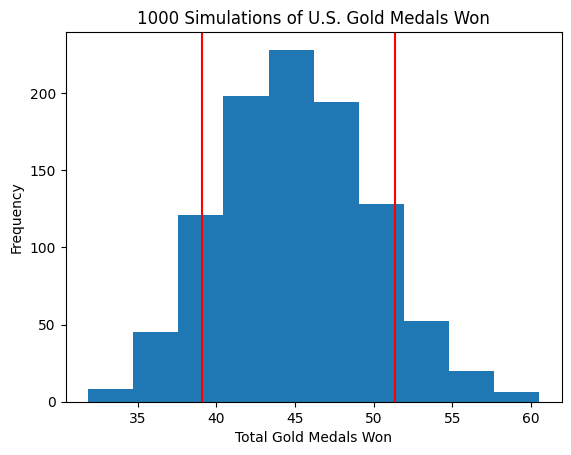

In [21]:
# Perform 1000 simulations and plot results with 80% CI

np.random.seed(1)

simulation_results = []

for i in range(1000):
    simulation_results.append(perform_one_simulation(sports_data))

lower = np.percentile(simulation_results, 10)
upper = np.percentile(simulation_results, 90)
print("Lower: " + str(lower))
print("Upper: " + str(upper))

plt.hist(simulation_results);
plt.title("1000 Simulations of U.S. Gold Medals Won");
plt.ylabel("Frequency");
plt.xlabel("Total Gold Medals Won");
plt.axvline(lower, color = "red");
plt.axvline(upper, color = "red");

# Beta Parameter Estimation Visualization

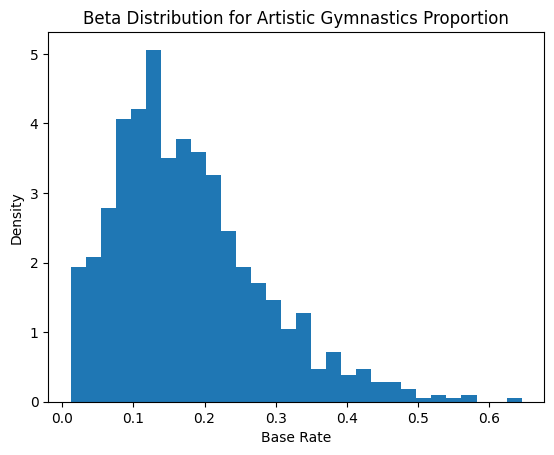

In [22]:
samples = []

for i in range(1000):
    mu = 0.172671
    var = 0.101015**2

    alpha = ((1 - mu)/var - 1/mu)*(mu**2)
    beta = alpha*(1/mu - 1)

    new_draw = np.random.beta(alpha, beta)
    samples.append(new_draw)

plt.hist(samples, density = True, bins = 30);
plt.title("Beta Distribution for Artistic Gymnastics Proportion");
plt.ylabel("Density");
plt.xlabel("Base Rate");